In [127]:
from __future__ import print_function, division
import glob
from astropy.io import fits
# import astropy.modeling.models as models
import numpy as np
# from scipy import stats
# import astropy.stats
from astropy import table
# from astropy import wcs
# from astropy import convolution
# import lupton_rgb
# import img_scale
import sys
sys.path.insert(1, '..')

In [128]:
%matplotlib inline
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['axes.grid'] = False

In [129]:
from IPython.display import display

In [130]:
# import blendcollection

In [131]:
import lsst.afw.table
import lsst.afw.image
import lsst.afw.math
import lsst.meas.algorithms
import lsst.meas.base
import lsst.meas.deblender
from astropy.table import Table
import numpy

def deblend_run(image_array, variance_array, psf_array):
    schema = lsst.afw.table.SourceTable.makeMinimalSchema()
    detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema)
#     detect.config.doTempLocalBackground = True
    deblend = lsst.meas.deblender.SourceDeblendTask(schema=schema)
    measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
    
    image_array = image_array.astype(np.float32).copy()
    image_array -= image_array[1:100,1:100].mean()

    image = lsst.afw.image.ImageF(image_array.astype(np.float32))
    variance = lsst.afw.image.ImageF(variance_array.astype(np.float32))
    masked_image = lsst.afw.image.MaskedImageF(image, None, variance)

    psf_image = lsst.afw.image.ImageD(psf_array.astype(np.float64))
    psf_kernel = lsst.afw.math.FixedKernel(psf_image)
    psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

    exposure = lsst.afw.image.ExposureF(masked_image)
    exposure.setPsf(psf)

    table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table
    detect_result = detect.run(table, exposure)

    catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty

    deblend.run(exposure, catalog)

    measure.run(catalog, exposure)
    return catalog

def _deblend_scene(scene, band='u', cutoff_sigma=3):
    idx = scene.bands_to_indices[band]
    std = numpy.std(scene.canvas[idx][1:100,1:100])
    variance = std**2
#     variance = np.average(scene.canvas[idx][0:10,0:10])
    stack_catalog = deblend_run(
        image_array=scene.canvas[idx],
        variance_array=np.ones_like(scene.canvas[idx]) * variance,
        psf_array=psf_hdulist[band.upper()].data,
    )
    stack_catalog.writeFits('./temp.fits')
    catalog = Table.read('./temp.fits')
    mask = catalog['base_PsfFlux_flux'] > 3 * std
    faint = catalog[~mask]
    good_catalog = catalog[mask]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(scene.canvas[idx], norm=LogNorm())
    ax.scatter(good_catalog['base_GaussianCentroid_x'], good_catalog['base_GaussianCentroid_y'], color='blue')
    ax.scatter(faint['base_GaussianCentroid_x'], faint['base_GaussianCentroid_y'], color='red')
    ymax, xmax = scene.canvas[idx].shape
    ax.set_xlim(0, ymax-1)
    ax.set_ylim(0, xmax-1)
    display(fig)
    return catalog

In [109]:
from lsst.meas.deblender.baseline import newDeblend

In [110]:
from lsst.meas.deblender.baseline import plugins

# Copypasta?

It looks like [lsst.meas.deblender.deblend.SourceDeblendTask.deblend](https://github.com/lsst/meas_deblender/blob/master/python/lsst/meas/deblender/deblend.py#L246) just calls [lsst.meas.deblender.baseline.deblend](https://github.com/lsst/meas_deblender/blob/master/python/lsst/meas/deblender/baseline.py#L447).

`lsst.meas.deblender.baseline.deblend` assembles a list of `meas.deblender.plugins.DeblenderPlugin` instances to pass to [newDeblend](https://github.com/lsst/meas_deblender/blob/master/python/lsst/meas/deblender/baseline.py#L672), which in turn loops over the plugins and runs them individually.

To enable the multicolor deblending, it looks like we need to call `newDeblend()` with some different plugins.

So we need to copy `lsst.meas.deblender.baseline.deblend()`.

In [111]:
def deblend(footprint, maskedImage, psf, psffwhm, filters=None,
            psfChisqCut1=1.5, psfChisqCut2=1.5, psfChisqCut2b=1.5, fitPsfs=True,
            medianSmoothTemplate=True, medianFilterHalfsize=2,
            monotonicTemplate=True, weightTemplates=False,
            log=None, verbose=False, sigma1=None, maxNumberOfPeaks=0,
            assignStrayFlux=True, strayFluxToPointSources='necessary', strayFluxAssignment='r-to-peak',
            rampFluxAtEdge=False, patchEdges=False, tinyFootprintSize=2,
            getTemplateSum=False, clipStrayFluxFraction=0.001, clipFootprintToNonzero=True,
            removeDegenerateTemplates=False, maxTempDotProd=0.5
            ):
    """Deblend a parent ``Footprint`` in a ``MaskedImageF``.
    
    Deblending assumes that ``footprint`` has multiple peaks, as it will still create a
    `PerFootprint` object with a list of peaks even if there is only one peak in the list.
    It is recommended to first check that ``footprint`` has more than one peak, similar to the
    execution of `lsst.meas.deblender.deblend.SourceDeblendTask`.
    .. note::
        This is the API for the old deblender, however the function builds the plugins necessary
        to use the new deblender to perform identically to the old deblender.
        To test out newer functionality use ``newDeblend`` instead.
    Deblending involves several mandatory and optional steps:
    # Optional: If ``fitPsfs`` is True, find all peaks that are well-fit by a PSF + background model
        * Peaks that pass the cuts have their footprints modified to the PSF + background model
          and their ``deblendedAsPsf`` property set to ``True``.
        * Relevant parameters: ``psfChisqCut1``, ``psfChisqCut2``, ``psfChisqCut2b``,
          ``tinyFootprintSize``.
        * See the parameter descriptions for more.
    # Build a symmetric template for each peak not well-fit by the PSF model
        * Given ``maskedImageF``, ``footprint``, and a ``DeblendedPeak``, creates a symmetric
          template (``templateImage`` and ``templateFootprint``) around the peak
          for all peaks not flagged as ``skip`` or ``deblendedAsPsf``.
        * If ``patchEdges=True`` and if ``footprint`` touches pixels with the
          ``EDGE`` bit set, then ``footprint`` is grown to include spans whose
          symmetric mirror is outside of the image.
        * Relevant parameters: ``sigma1`` and ``patchEdges``.
    # Optional: If ``rampFluxAtEdge`` is True, adjust flux on the edges of the template footprints
        * Using the PSF, a peak ``Footprint`` with pixels on the edge of of ``footprint``
          is grown by the psffwhm*1.5 and filled in with zeros.
        * The result is a new symmetric footprint template for the peaks near the edge.
        * Relevant parameter: ``patchEdges``.
    # Optionally (``medianSmoothTemplate=True``) filter the template images
        * Apply a median smoothing filter to all of the template images.
        * Relevant parameters: ``medianFilterHalfSize``
    # Optional: If ``monotonicTemplate`` is True, make the templates monotonic.
        * The pixels in the templates are modified such that pixels
          further from the peak will have values smaller than those closer to the peak.
    # Optional: If ``clipFootprintToNonzero`` is True, clip non-zero spans in the template footprints
        * Peak ``Footprint``s are clipped to the region in the image containing non-zero values
          by dropping spans that are completely zero and moving endpoints to non-zero pixels
          (but does not split spans that have internal zeros).
    # Optional: If ``weightTemplates`` is True,  weight the templates to best fit the observed image
        * Re-weight the templates so that their linear combination
          best represents the observed ``maskedImage``
    # Optional: If ``removeDegenerateTempaltes`` is True, reconstruct shredded galaxies
        * If galaxies have substructure, such as face-on spirals, the process of identifying peaks can
          "shred" the galaxy into many pieces. The templates of shredded galaxies are typically quite
          similar because they represent the same galaxy, so we try to identify these "degenerate" peaks
          by looking at the inner product (in pixel space) of pairs of templates.
        * If they are nearly parallel, we only keep one of the peaks and reject the other.
        * If only one of the peaks is a PSF template, the other template is used,
          otherwise the one with the maximum template value is kept.
        * Relevant parameters: ``maxTempDotProduct``
    # Apportion flux to all of the peak templates
        * Divide the ``maskedImage`` flux amongst all of the templates based on the fraction of 
          flux assigned to each ``tempalteFootprint``.
        * Leftover "stray flux" is assigned to peaks based on the other parameters.
        * Relevant parameters: ``clipStrayFluxFraction``, ``strayFluxAssignment``,
          ``strayFluxToPointSources``, ``assignStrayFlux``
    
    Parameters
    ----------
    footprint: `afw.detection.Footprint`
        Parent footprint to deblend
    maskedImage: `afw.image.MaskedImageF`
        Masked image containing the ``footprint``
    psf: `afw.detection.Psf`
        Psf of the ``maskedImage``
    psffwhm: `float`
        FWHM of the ``maskedImage``'s ``psf``
    psfChisqCut*: `float`, optional
        If ``fitPsfs==True``, all of the peaks are fit to the image PSF.
        ``psfChisqCut1`` is the maximum chi-squared-per-degree-of-freedom allowed for a peak to
        be considered a PSF match without recentering.
        A fit is also made that includes terms to recenter the PSF.
        ``psfChisqCut2`` is the same as ``psfChisqCut1`` except it determines the restriction on the
        fit that includes recentering terms.
        If the peak is a match for a re-centered PSF, the PSF is repositioned at the new center and
        the peak footprint is fit again, this time to the new PSF.
        If the resulting chi-squared-per-degree-of-freedom is less than ``psfChisqCut2b`` then it
        passes the re-centering algorithm.
        If the peak passes both the re-centered and fixed position cuts, the better of the two is accepted,
        but parameters for all three psf fits are stored in the ``DeblendedPeak``.
        The default for ``psfChisqCut1``, ``psfChisqCut2``, and ``psfChisqCut2b`` is ``1.5``.
    fitPsfs: `bool`, optional
        If True then all of the peaks will be compared to the image PSF to
        distinguish stars from galaxies.
    medianSmoothTemplate: ``bool``, optional
        If ``medianSmoothTemplate==True`` it a median smoothing filter is applied to the ``maskedImage``.
        The default is ``True``.
    medianFilterHalfSize: `int`, optional
        Half the box size of the median filter, ie a ``medianFilterHalfSize`` of 50 means that
        each output pixel will be the median of  the pixels in a 101 x 101-pixel box in the input image.
        This parameter is only used when ``medianSmoothTemplate==True``, otherwise it is ignored.
        The default value is 2.
    monotonicTempalte: `bool`, optional
        If True then make the template monotonic.
        The default is True.
    weightTemplates: `bool`, optional
        If True, re-weight the templates so that their linear combination best represents
        the observed ``maskedImage``.
        The default is False.
    log: `log.Log`, optional
        LSST logger for logging purposes.
        The default is ``None`` (no logging).
    verbose: `bool`, optional
        Whether or not to show a more verbose output.
        The default is ``False``.
    sigma1: `float`, optional
        Average noise level in ``maskedImage``.
        The default is ``None``, which estimates the noise from the median value of ``maskedImage``.
    maxNumberOfPeaks: `int`, optional
        If nonzero, the maximum number of peaks to deblend.
        If the total number of peaks is greater than ``maxNumberOfPeaks``,
        then only the first ``maxNumberOfPeaks`` sources are deblended.
        The default is 0, which deblends all of the peaks.
    assignStrayFlux: `bool`, optional
        If True then flux in the parent footprint that is not covered by any of the
        template footprints is assigned to templates based on their 1/(1+r^2) distance.
        How the flux is apportioned is determined by ``strayFluxAssignment``.
        The default is True.
    strayFluxToPointSources: `string`
        Determines how stray flux is apportioned to point sources
        * ``never``: never apportion stray flux to point sources
        * ``necessary`` (default): point sources are included only if there are no extended sources nearby
        * ``always``: point sources are always included in the 1/(1+r^2) splitting
    strayFluxAssignment: `string`, optional
        Determines how stray flux is apportioned.
        * ``trim``: Trim stray flux and do not include in any footprints
        * ``r-to-peak`` (default): Stray flux is assigned based on (1/(1+r^2) from the peaks
        * ``r-to-footprint``: Stray flux is distributed to the footprints based on 1/(1+r^2) of the
          minimum distance from the stray flux to footprint
        * ``nearest-footprint``: Stray flux is assigned to the footprint with lowest L-1 (Manhattan)
          distance to the stray flux
    rampFluxAtEdge: `bool`, optional
        If True then extend footprints with excessive flux on the edges as described above.
        The default is False.
    patchEdges: `bool`, optional
        If True and if the footprint touches pixels with the ``EDGE`` bit set,
        then grow the footprint to include all symmetric templates.
        The default is ``False``.
    tinyFootprintSize: `float`, optional
        The PSF model is shrunk to the size that contains the original footprint.
        If the bbox of the clipped PSF model for a peak is smaller than ``max(tinyFootprintSize,2)``
        then ``tinyFootprint`` for the peak is set to ``True`` and the peak is not fit.
        The default is 2.
    getTemplateSum: `bool`, optional
        As part of the flux calculation, the sum of the templates is calculated.
        If ``getTemplateSum==True`` then the sum of the templates is stored in the result (a `PerFootprint`).
        The default is False.
    clipStrayFluxFraction: `float`, optional
        Minimum stray-flux portion.
        Any stray-flux portion less than ``clipStrayFluxFraction`` is clipped to zero.
        The default is 0.001.
    clipFootprintToNonzero: `bool`, optional
        If True then clip non-zero spans in the template footprints. See above for more.
        The default is True.
    removeDegenerateTemplates: `bool`, optional
        If True then we try to identify "degenerate" peaks by looking at the inner product
        (in pixel space) of pairs of templates.
        The default is False.
    maxTempDotProduct: `float`, optional
        All dot products between templates greater than ``maxTempDotProduct`` will result in one
        of the templates removed. This parameter is only used when ``removeDegenerateTempaltes==True``.
        The default is 0.5.
    
    Returns
    -------
    res: `PerFootprint`
        Deblender result that contains a list of ``DeblendedPeak``s for each peak and (optionally)
        the template sum.
    """
    avgNoise = sigma1

    debPlugins = []

    # Add activated deblender plugins
    if fitPsfs:
        debPlugins.append(plugins.DeblenderPlugin(plugins.fitPsfs, 
                                                  psfChisqCut1=psfChisqCut1,
                                                  psfChisqCut2=psfChisqCut2,
                                                  psfChisqCut2b=psfChisqCut2b,
                                                  tinyFootprintSize=tinyFootprintSize))
    debPlugins.append(plugins.DeblenderPlugin(plugins.buildSymmetricTemplates, patchEdges=patchEdges))
    if rampFluxAtEdge:
        debPlugins.append(plugins.DeblenderPlugin(plugins.rampFluxAtEdge, patchEdges=patchEdges))
    if medianSmoothTemplate:
        debPlugins.append(plugins.DeblenderPlugin(plugins.medianSmoothTemplates,
                                                  medianFilterHalfsize=medianFilterHalfsize))
    if monotonicTemplate:
        debPlugins.append(plugins.DeblenderPlugin(plugins.makeTemplatesMonotonic))
    if clipFootprintToNonzero:
        debPlugins.append(plugins.DeblenderPlugin(plugins.clipFootprintsToNonzero))
    if weightTemplates:
        debPlugins.append(plugins.DeblenderPlugin(plugins.weightTemplates))
    if removeDegenerateTemplates:
        if weightTemplates:
            onReset = len(debPlugins)-1
        else:
            onReset = len(debPlugins)
        debPlugins.append(plugins.DeblenderPlugin(plugins.reconstructTemplates,
                                                  onReset=onReset,
                                                  maxTempDotProd=maxTempDotProd))
    debPlugins.append(plugins.DeblenderPlugin(plugins.apportionFlux,
                                              clipStrayFluxFraction=clipStrayFluxFraction,
                                              assignStrayFlux=assignStrayFlux,
                                              strayFluxAssignment=strayFluxAssignment,
                                              strayFluxToPointSources=strayFluxToPointSources,
                                              getTemplateSum=getTemplateSum))

    debResult = newDeblend(debPlugins, footprint, maskedImage, psf, psffwhm, filters, log, verbose, avgNoise)

    return debResult

In [112]:
def quick_deblend_mono(scene_data, psf_data):
    # Given NumPy float32 arrays containing the image to be measured and its variance, make an LSST
    # "MaskedImage" to hold them.  This also holds a mask, which we'll set to None to make a blank mask.
    image = lsst.afw.image.ImageF(scene_data.astype(np.float32))
    variance = lsst.afw.image.ImageF(scene_data.astype(np.float32))
    masked_image = lsst.afw.image.MaskedImageF(image, None, variance)
    # Create a PSF object from a NumPy array of the PSF image.  This should have odd dimensions, and be
    # centered on the center pixel.
    psf_image = lsst.afw.image.ImageD(psf_data.astype(np.float64))
    psf_kernel = lsst.afw.math.FixedKernel(psf_image)
    psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
    deblend(footprint, maskedImage, psf, psffwhm)

In [113]:
test_img = fits.open('../synthetic/outputs/TwoGalaxies-A/delta_mag_1/delta_z_2.0/sep_1.250_arcsec.fits')

In [114]:
test_img.info()

Filename: ../synthetic/outputs/TwoGalaxies-A/delta_mag_1/delta_z_2.0/sep_1.250_arcsec.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      11   ()              
1    BLENDED     ImageHDU         9   (64, 64, 5)   float64   
2    TRUTH       ImageHDU         9   (128, 128, 5)   float64   
3    BANDS       BinTableHDU     14   5R x 2C      [1A, E]   
4    CATALOG     BinTableHDU     46   2R x 15C     [E, E, E, E, E, E, 20A, E, E, 20A, 5E, I, E, E, E]   


In [115]:
test_img_psf = fits.open('../synthetic/outputs/TwoGalaxies-A/chromatic_gaus_0.7_arcsec_sdss_i.fits')
test_img_psf.info()

Filename: ../synthetic/outputs/TwoGalaxies-A/chromatic_gaus_0.7_arcsec_sdss_i.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   ()              
1    U           ImageHDU        10   (25, 25)     float64   
2    G           ImageHDU        10   (25, 25)     float64   
3    R           ImageHDU        10   (25, 25)     float64   
4    I           ImageHDU        10   (25, 25)     float64   
5    Z           ImageHDU        10   (25, 25)     float64   


In [116]:
quick_deblend_mono(test_img['BLENDED'].data[0], test_img_psf['U'].data)

NameError: global name 'maskedImage' is not defined

One way to create a `lsst.afw.detection.Footprint()` is with `__init__(lsst::afw::detection::Footprint self, Box2I bbox)`. So, probably we want a bounding box the size of our thing. That could be a problem for background estimation, I guess.

Maybe instead we construct spans? `__init__(lsst::afw::detection::Footprint self, SpanContainerT spans)` is allowed.

In [117]:
x= lsst.afw.geom.Box2I()

In [118]:
lsst.afw.geom.SpanVector([])

<lsst.afw.geom.geomLib.SpanVector; proxy of <Swig Object of type 'std::vector< lsst::afw::geom::Span > *' at 0x7f258397d090> >

In [119]:
lsst.afw.detection.Footprint()

<lsst.afw.detection.detectionLib.Footprint; proxy of <Swig Object of type 'std::shared_ptr< lsst::afw::detection::Footprint > *' at 0x7f2583990c00> >

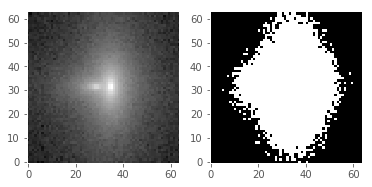

In [120]:
plt.subplot(121)
plt.imshow(test_img['BLENDED'].data[0], norm=LogNorm())
plt.subplot(122)
plt.imshow((test_img['BLENDED'].data[0] > 50).reshape(test_img['BLENDED'].data[0].shape))

In [121]:
test_img['BLENDED'].data[0] > 20

array([[False, False, False, ...,  True, False, False],
       [ True,  True, False, ...,  True,  True, False],
       [False,  True, False, ...,  True,  True, False],
       ..., 
       [ True, False,  True, ...,  True, False, False],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False]], dtype=bool)

In [122]:
# def quick_deblend(scene_data, psf_data):
scene_data = test_img['BLENDED'].data[0]
psf_data = test_img_psf['U'].data
# High-level algorithms are in classes called "Tasks".  Each of these has a Config
# class to control how it runs; to use it, construct an instance of Task.ConfigClass(),
# set attributes on it, and pass that as the config kwarg to the Task constructor.
# It's usually a good idea to construct all Tasks before using any of them, mostly
# to define the full schema of any catalogs we'll produce up front.
schema = lsst.afw.table.SourceTable.makeMinimalSchema()
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema)
deblend = lsst.meas.deblender.SourceDeblendTask(schema=schema)
measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
# Given NumPy float32 arrays containing the image to be measured and its variance, make an LSST
# "MaskedImage" to hold them.  This also holds a mask, which we'll set to None to make a blank mask.
image = lsst.afw.image.ImageF(scene_data.astype(np.float32))
variance = lsst.afw.image.ImageF(scene_data.astype(np.float32))
masked_image = lsst.afw.image.MaskedImageF(image, None, variance)
# Create a PSF object from a NumPy array of the PSF image.  This should have odd dimensions, and be
# centered on the center pixel.
psf_image = lsst.afw.image.ImageD(psf_data.astype(np.float64))
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
# Create an Exposure object that combines the MaskedImage with the PSF.  Exposures can hold
# quite a bit more (WCS, photometric zeropoint (`Calib`), but I think this is all we need for now.
exposure = lsst.afw.image.ExposureF(masked_image)
exposure.setPsf(psf)
# Run the tasks
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table
detect_result = detect.run(table, exposure)
catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
deblend.run(exposure, catalog)
# measure.run(catalog, exposure)
# catalog = catalog.copy(deep=True)
# catalog.writeFits('./detections.fits')
# t = Table.read('./detections.fits', hdu=1)
# os.remove('./detections.fits')
# return t

In [123]:
def footprintToImage(fp, mi=None, mask=False):
    if fp.isHeavy():
        try:
            fp = lsst.afw.detection.cast_HeavyFootprintF(fp) # not needed with pybind11
        except AttributeError:
            pass
        pass
    elif mi is None:
        print >> sys.stderr, "Unable to make a HeavyFootprint as image is None"
    else:
        fp = lsst.afw.detection.makeHeavyFootprint(fp, mi)
    bb = fp.getBBox()
    if mask:
        im = lsst.afw.image.MaskedImageF(bb.getWidth(), bb.getHeight())
    else:
        im = lsst.afw.image.ImageF(bb.getWidth(), bb.getHeight())
    im.setXY0(bb.getMinX(), bb.getMinY())

    try:
        fp.insert(im)
    except AttributeError:              # we failed to make it heavy
        assert not mi
        pass
    
    if mask:
        im = im.getMask()
    return im

0
1
2


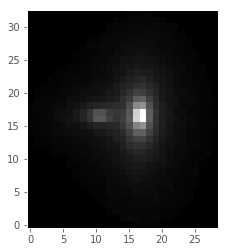

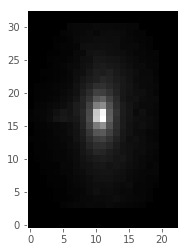

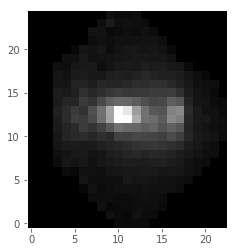

In [124]:
for i, src in enumerate(catalog):
    footprint = src.getFootprint()
    print(i)
    plt.figure()
    if not footprint.isHeavy():
        plt.imshow(footprintToImage(src.getFootprint(), mi=masked_image).getArray())
    if i != 0:
        plt.imshow(footprintToImage(src.getFootprint()).getArray())

In [125]:
footprint = src.getFootprint()

In [126]:
footprint.isHeavy()

True

In [86]:
fimg = lsst.afw.image.ImageI(footprint.getBBox())
fimg.getArray()[:, :] = np.nan

In [87]:
footprint.insertIntoImage(fimg, 1)

InvalidParameterError: 
  File "src/detection/Footprint.cc", line 599, in void lsst::afw::detection::{anonymous}::doInsertIntoImage(const lsst::afw::geom::Box2I&, const SpanList&, lsst::afw::image::Image<RhsPixelT>&, uint64_t, const lsst::afw::geom::Box2I&, long int, std::set<long unsigned int>*) [with bool overwriteId = false; PixelT = int; lsst::afw::detection::Footprint::SpanList = std::vector<std::shared_ptr<lsst::afw::geom::Span> >; uint64_t = long unsigned int]
    Image of size (23x25) doesn't match Footprint's host Image of size (0x0) {0}
lsst::pex::exceptions::InvalidParameterError: 'Image of size (23x25) doesn't match Footprint's host Image of size (0x0)'


In [80]:
spans = footprint.getSpans()

In [82]:
for span in spans.iterator():
    print(span)

19: 28..31
20: 27..32
21: 26..33
22: 25..33
23: 24..35
24: 24..36
25: 22..37
26: 21..38
27: 19..39
28: 19..39
29: 18..40
30: 18..40
31: 18..40
32: 18..40
33: 18..40
34: 19..39
35: 19..39
36: 20..38
37: 21..36
38: 22..34
39: 23..34
40: 25..33
41: 25..32
42: 26..31
43: 27..30


In [90]:
deblender.footprintToImage(kid.getFootprint(), calexp.getMaskedImage())

NameError: name 'deblender' is not defined

In [91]:
import lsst.analysis

ImportError: No module named analysis

In [89]:
import lsst.analysis. .utils as utils
import lsst.analysis.deblender as deblender

ImportError: No module named analysis.utils

Okay well I'll just copy and paste..

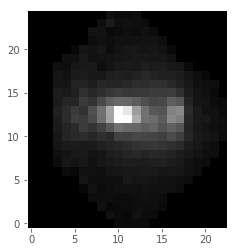

In [100]:
plt.imshow(footprintToImage(footprint).getArray())